In [16]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

In [17]:
X_train = pd.read_csv("./data/X_train.csv", encoding='utf-8')
X_test = pd.read_csv("./data/X_test.csv", encoding='utf-8')
y_train = pd.read_csv("./data/y_train.csv", encoding='utf-8')
y_test = pd.read_csv("./data/y_test.csv", encoding='utf-8')

In [18]:
xgb_model = GradientBoostingRegressor()

In [19]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 20, 30, 50],
    'min_samples_leaf': [1, 2, 4, 8, 10, 20],
    'subsample': [0.5, 0.75, 0.9, 1.0],
    'max_features': [0.75, None],
    'loss': ['squared_error', 'absolute_error']
}

In [20]:
random_search = RandomizedSearchCV(xgb_model, param_dist, cv=5, verbose=2, n_jobs=-1, scoring="neg_mean_absolute_error")

In [21]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5, 1.0],
                                        'loss': ['squared_error',
                                                 'absolute_error'],
                                        'max_depth': [5, 6, 7, 8, 9, 10],
                                        'max_features': [0.75, None],
                                        'min_samples_leaf': [1, 2, 4, 8, 10,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              50],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.75, 0.9, 1.0]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [22]:
results_random = pd.DataFrame(random_search.cv_results_)
results_random.sort_values(by="rank_test_score", inplace=True)

In [23]:
print(f"Best MAE from random search: {random_search.best_score_}")
print(f"Best params from random search: {random_search.best_params_}")

Best MAE from random search: -0.03311179653890379
Best params from random search: {'subsample': 0.75, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 6, 'loss': 'squared_error', 'learning_rate': 0.1}


In [ ]:
# grid_search = GridSearchCV(xgb_model, param_dist, cv=5, verbose=2, n_jobs=-1, scoring="neg_mean_absolute_error")

In [ ]:
# grid_search.fit(training_data.drop(columns=[y_col]), training_data[y_col])

In [ ]:
# results_grid = pd.DataFrame(grid_search.cv_results_)
# results_grid.sort_values(by="rank_test_score", inplace=True)

In [ ]:
# print(f"Best MAE from grid search: {grid_search.best_score_}")
# print(f"Best params from grid search: {grid_search.best_params_}")

In [24]:
model = GradientBoostingRegressor(subsample=0.75, n_estimators=400, min_samples_split=10, min_samples_leaf=20, max_features=None, max_depth=6, loss='squared_error', learning_rate=0.1)

In [25]:
model.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor(max_depth=6, min_samples_leaf=20,
                          min_samples_split=10, n_estimators=400,
                          subsample=0.75)

In [26]:
y_pred = model.predict(X_test)

In [27]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [28]:
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.035254684939677323
Mean Squared Error: 0.0027014653085352604
R-squared: 0.5972716700251672


In [29]:
# for residuales, convert df to series
y_test_series = y_test.squeeze()

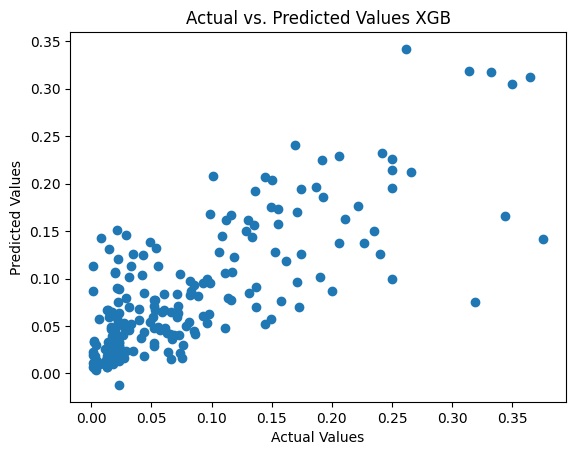

In [30]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values XGB')
plt.show()

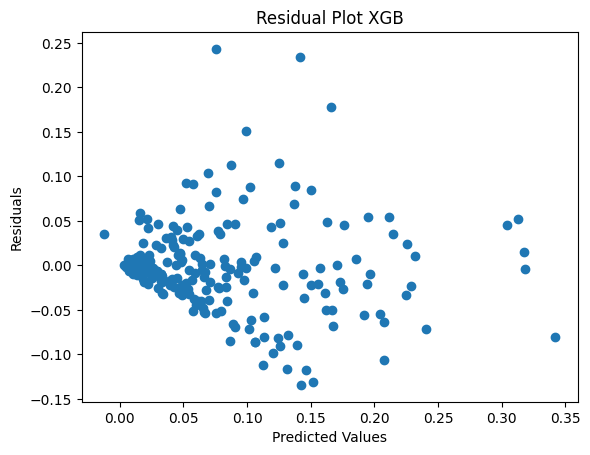

In [31]:
residuals = y_test_series - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot XGB')
plt.show()